# Linear deterministic generating functions

Perception in a passive agent using linear deterministic generating functions.

==========================================================================

* **Notebook dependencies**:
    * ...

* **Content**: Jupyter notebook accompanying Chapter 2 of the textbook "Fundamentals of Active Inference"

* **Author**: Sanjeev Namjoshi (sanjeev.namjoshi@gmail.com)

* **Version**: 0.1

In [1]:
import matplotlib.pyplot as plt
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from scipy.stats import norm, uniform
from types import SimpleNamespace

mpl.style.use("seaborn-deep")
# mpl.style.use("seaborn-v0_8-deep")

In Chapter 2 we explore a number of different experiments to illustrate the process of hidden state estimation. We explore two variants in this section of Chapter 2:
* Linear and deterministic
* Linear and probabilistic

The modeling framework introduced in Chapter 2 consists of the following steps:

1. Define the experimental setting (states and observations)
2. Define the generative process (*environment*)
3. Define the generative model (*agent*)
4. Run the simulation and iterate the following steps:
   1. Infer hidden states (*perception*)
   2. Control the generative process (*planning, decision-making, action*)
   3. Update model parameters (*learning*)

We assume in this simple scenario that the "control the generative process" and "update model parameters" step do not apply. Therefore, what we will create is a passive agent that can only perform perception. 

## Setting up the simulation

Step 1: **Define the experimental setting (states and observations)**.

We will rely on the following variables:
* $x$: The true **hidden state** of the generative process.
* $y$: The *outcome* of a generative process, known as the **observation** for a generative model. This is the data the agent receives.

In this scenario the states of the generative process ($x$) denote the size of a food source and the outcomes ($y$) are different levels of light intensity emitted from the food as a function of size. Using these observations, the agent needs to infer (*perceive*) the hidden state of the generative process that generated the data it is receiving. 

Step 2: **Define the generative process**.

$$
    \mathscr{E} \triangleq
    \begin{cases}
        y = g_{\mathscr{E}}(x^*; \theta^*) & \text{Outcome generation} \\
        g_{\mathscr{E}}(x^*; \theta^*) = \beta_0^* + \beta_1^* x^* & \text{Generating function} \\
        \theta^* = \left \{\beta_0^*, \beta_1^* \right \} & \text{Parameters}
    \end{cases}
$$

<span style="color:red">This is equation $2.3$.</span>

Here $g_{\mathscr{E}}(x^*; \theta^*)$ is a linear function representing sensory data $y$ generated while in a particular external state $x^*$. This function takes two parameters, defined in the set $\theta^*$ which are set at $\beta^*_0 = 3$ and $\beta^*_1=2$ in this example. Note that this generative process has no noise. Our aim is to express this environment in terms code. 

Although it is convenient to collect the parameters into a set $\theta^*$ in the math notation we will simply pass in the individual parameters $\beta^*_0$ and $\beta^*_1$ into the function for cleaner code.

In [5]:
def ge(x_star: float, beta_star_0: float, beta_star_1: float) -> float:
    y = beta_star_1 * x_star + beta_star_0
    return y

Next, let's visualize this function for a range of $x^*$ states (food size) and resulting $y$ observations (light intensity).

<Figure size 640x480 with 0 Axes>

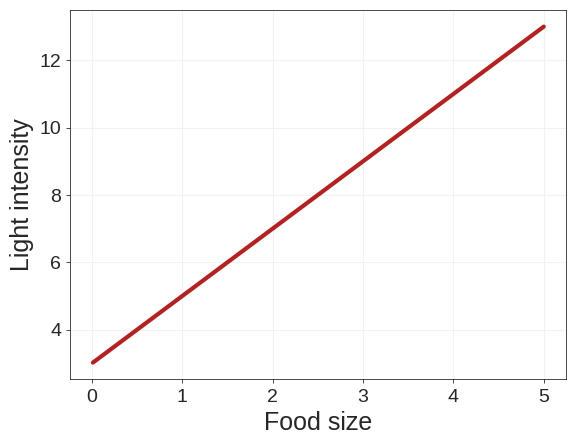

In [6]:
# Get y values across the range of x
x_range = np.linspace(start=0.01, stop=5, num=500)
y_i = ge(x_range, beta_star_0=3, beta_star_1=2)

# Plot
plt.style.use("seaborn-whitegrid")
fig = plt.figure()
fig, ax = plt.subplots(1, 1, facecolor=(1,1,1))

# Plot linear generating function on canvas
ax.plot(x_range, y_i, c="#b22222", linewidth=3)

ax.set_xlabel("Food size", fontsize=18)
ax.set_ylabel("Light intensity", fontsize=18)

# Axis labels and styling
ax.axes.grid(which="major", axis="both", c="#f2f2f2")
plt.setp(ax.spines.values(), color="black", linewidth=0.5)
ax.tick_params(
    labelsize=14,
    axis='both',          
    which='major',      
    bottom=True,
    left=True,
    color="black",
    width=0.5,
    length=3)

Although the `ge()` function alone is sufficient to describe the generative process, it will be instructive to put it into a `StaticEnvironment` class. Doing so will reinforce the notion of the separation between the agent and environment and enable us to see how they interact. 

In [7]:
class StaticEnvironment:
    def __init__(self, params: dict) -> None:
        self.params = SimpleNamespace(**params)
    
    def _ge(self, x_star: float) -> float:
        return self.params.beta_1_star * x_star + self.params.beta_0_star
    
    def generate(self, x_star: float) -> float:
        return self._ge(x_star)

To generate observations with this environment, we first need to specify the model parameters upon initializing the `StaticEnvironment` class. Then we can run the `generate()` function to generate an observation. In this example we will assume that $x^*=2$.

In [8]:
# Environment parameters
env_params = {
    "beta_0_star" : 3,    # Linear parameter intercept
    "beta_1_star" : 2,    # Linear parameter slope
}

# Initialize the environment
env       = StaticEnvironment(env_params)

# Set true state and generate sensory data
x_star    = 2
y         = env.generate(x_star)

print(f"When the external state is 2, the sensory data generated will be {y}.")

When the external state is 2, the sensory data generated will be 7.


## Example 2.1: A linear, deterministic generative model

Step 3: **Define the generative model**. The model, $\mathcal{M}$ is represented as follows:

$$
    \mathcal{M} \triangleq
    \begin{cases}
        p_{\mu_y, \sigma^2_y}(y \mid x) = \mathcal{N}(y; g_{\mathcal{M}}, \sigma^2_y) \approx \delta(x - g_{\mathcal{M}}(x; \theta))& \text{Likelihood} \\
        p_{a_x, b_x}(x) = \mathcal{U}(x; a_x, b_x) & \text{State prior} \\
        g_{\mathcal{M}}(x; \theta) = \beta_0 + \beta_1 x & \text{Generating function} \\
        \theta := \left \{\beta_0 = 3, \beta_1 = 2 \right \} & \text{Linear parameters} \\
        \phi := \left \{\sigma^2_y \rightarrow 0, a_x = 0, b_x = 5 \right \} & \text{Other parameters} 
    \end{cases}
$$

<span style="color:red">This is equation 2.11 from the text.</span>

As a reminder, in this demonstration we have assumed that learning has already occurred so the parameters will be set in advance, as seen in the entry for $\text{linear parameters}$ and $\text{Other parameters}$ above. Therefore, we are skipping Step 4.3: **Learn model parameters** for this chapter (as well as skipping Step 4.2). 

We will choose a likelihood that has zero variance for this demonstration so that it is deterministic (i.e. not probabilistic). Without uncertainty, the distribution's density reduces to a point, which we can describe with a Dirac $\delta$ function. We can approximate this in our example by simply making the variance of the likelihood tiny. The prior distribution will be **improper** but will not have an effect on the inference process. 

Now we attempt to replicate the generative model in code. To do so, we need to define the likelihood ($p(y \mid x)$) and prior ($p(x)$) as indicated by the math notation. Although we could define the sets for the linear and other parameters, we will omit them from the code for simplicity.

In this case we will assume that the agent's generating function is isomorphic to the generative process. In other words, $g_{\mathcal{M}} = g_{\mathscr{E}}$. This function essentially captures the agent's expectation of what sensory data would result from a particular hidden state $x$.

Remember that the likelihood function starts with the conditional distribution $p(y \mid x)$ and then we hold $y$ fixed (passing in the observation) and vary $x$ across its range. We are not just interested in the likelihood over a single value of $x$ but of *all* values of $x$ in the simulation as specified by `x_range` for the given $y$ observation. For the prior, we are specifying a flat prior probability over the entire `x_range`. Finally, the generative model is the product of the likelihood and prior:

$$
p(x, y) = p(y \mid x) p(x)
$$

The Linear Generating Function: $g_{\mathcal{M}}(x; \theta) = \beta_0 + \beta_1 x$

In [10]:
# the generative model's specific, linear generating function. This is g_M. 
def gm(x: float, beta_0: float, beta_1: float) -> float:
    return beta_1 * x + beta_0

The Generative Model: $p(x, y) = p(y \mid x) p(x)$

In [11]:
# the generative model itself is the product of the likelihood and prior distributions
def generative_model(x_range: np.ndarray, y: float, beta_0: float, beta_1: float, std_y : float, ax: float, bx: float) -> np.ndarray:
    likelihood = norm.pdf(y, loc=gm(x_range, beta_0, beta_1), scale=std_y)
    prior      = uniform.pdf(x_range, loc=ax, scale=bx-ax)
    return likelihood * prior

With these functions in hand, we can determine our generative model given an observation $y$ over the range of $x$. First, we use the environment to generate an observation and then pass this to the generative model. Here we specify the likelihood standard deviation to be tiny in order to approximate a Dirac $\delta$ function. Additionally, the uniform prior is defined over the range of $x$ (0.01 to 5).

In [12]:
# Environment parameters
env_params = {
    "beta_0_star" : 3,    # Linear parameter intercept
    "beta_1_star" : 2,    # Linear parameter slope
}

# Initialize the environment
env       = StaticEnvironment(env_params)

# Set true state and generate sensory data
x_star    = 3.5
y         = env.generate(x_star)

# Define the generative model -> p(x, y)  = p(y | x)p(x)
gen_model = generative_model(
    x_range = x_range, y = y,
    beta_0 = 3, beta_1 = 2,
    std_y = float(1./100), ax = 0.01, bx = 5.0
)

Step 5: **Infer hidden states**

With the generative model in hand we are ready to invert it using Bayes' theorem:

$$
p(x \mid y) = \frac{p(x,y)}{p(y)} = \frac{p(y \mid x)p(x)}{\int p(y \mid x)p(x) dx}
$$

We already have the generative model $p(x,y)$. The evidence term $p(y)$ is calculated by integrating the generative model over the states. Since we are using grid approximation in this example and approximating continuous probability distributions as discrete samples this integral will become a sum. 

In [13]:
# p(y) = integral_x of p(x, y); approximated in our grid with a sum
evidence = np.sum(gen_model, axis=0)  

# p(x | y) = p(x, y) / p(y)
posterior = gen_model / evidence

To reinforce the nature of the agent-environment interaction we will put the generative model into its own class. Continuing forward we will use this class construction instead of the free functions.

In [14]:
class StaticAgent:
    def __init__(self, params: dict) -> None:
        self.params = SimpleNamespace(**params)
        
        self.likelihood = None
        self.prior = None
        
    def gm(self):
        return self.params.beta_1 * self.params.x_range + self.params.beta_0
        
    def generative_model(self, y: float):
        self.likelihood = norm.pdf(y, loc=self.gm(), scale=self.params.std_y)
        self.prior      = uniform.pdf(self.params.x_range, loc=self.params.ax, scale=self.params.bx-self.params.ax)
        return self.likelihood * self.prior
        
    def infer_state(self, y: float):
        gen_model = self.generative_model(y)
        evidence  = np.sum(gen_model, axis=0)
        posterior = gen_model / evidence
        return posterior

Now we put it all together and plot the results. <span style="color:red">The resulting plot will generate Figure 2.7.</span>

In [15]:
# Environment parameters
env_params = {
    "beta_0_star" : 3,    # Linear parameter intercept
    "beta_1_star" : 2,    # Linear parameter slope
}

# Agent parameters
agent_params = {
    "beta_0" : 3,              # Linear parameter intercept
    "beta_1" : 2,              # Linear parameter slope
    "std_y"  : float(1./100),  # Likelihood standard deviation
    "ax"     : 0.01,           # Prior uniform lower bound
    "bx"     : 5.0,            # Prior uniform upper bound
    "x_range": np.linspace(start=0.01, stop=5, num=500)
}

In [16]:
# Initialize environment and agent
env       = StaticEnvironment(env_params)
agent     = StaticAgent(agent_params)

# Set true state and generate sensory data
x_star    = 3.5
y         = env.generate(x_star)

# Perception: Agent infers belief over hidden state using sensory data
posterior = agent.infer_state(y)

<Figure size 640x480 with 0 Axes>

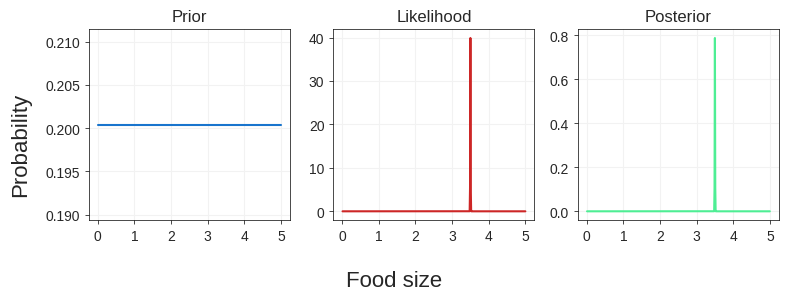

In [19]:
plt.style.use("seaborn-whitegrid")
fig = plt.figure()
fig, axes = plt.subplots(1,3, facecolor=(1,1,1), figsize=(8,3))

# Get likelihood and prior from agent
likelihood = agent.likelihood
prior = agent.prior

# Main plot
axes[0].plot(x_range.tolist(), prior, c="#1874cd")        # Prior
axes[1].plot(x_range.tolist(), likelihood, c="#cd2626")   # Likelihood
axes[2].plot(x_range.tolist(), posterior, c="#4eee94")    # Posterior

# Titles
axes[0].set_title("Prior")
axes[1].set_title("Likelihood")
axes[2].set_title("Posterior")

# Axis global labels
fig.supxlabel("Food size", fontsize=16)
fig.supylabel("Probability", fontsize=16)

# Cosmetic changes and axes ranges
for ax in axes:
    ax.xaxis.set_ticks(np.arange(0, 6, 1))
    ax.axes.grid(which="major", axis="both", c="#f2f2f2")
    plt.setp(ax.spines.values(), color="black", linewidth=0.5)
    ax.tick_params(
        axis='both',          
        which='major',      
        bottom=True,
        left=True,
        color="black",
        width=0.5,
        length=3)
    
fig.tight_layout()

# TO DO: Add Density, Credibility and Density y_tick labels to each respective graph.


To recap, we have just done Bayesian inference in the case where everything is deterministic and we have no prior assumptions (uniform prior).

We can see that the likelihood gives us a "*credibility*" (i.e. not a probability) about the probability of generating the data we observed over the range of $x$. To get the *probability* of observing that data we need to normalize the likelihood after multiplying by the prior.

Now to see how good our estimate is, let's first calculate the posterior mode which corresponds to the most likely value of $x$ given the observed data. We can achieve this using the `argmax()` function on the posterior which will return the value of $x$ (food size) which has the maximum probability in the posterior.

**Note**: When calculating `argmax()` it's in terms of the scale of the grid which ranges from 0.01-500. But we want food size in terms of 0-5 so the adjustment of adding one and dividng by 100 is necessary to get the scales to line up.

In [20]:

mode = (np.argmax(posterior) + 1) / 100
print(f'The posterior mode is {mode}. This is the food size when the observed light intensity is 10.')

The posterior mode is 3.5. This is the food size when the observed light intensity is 10.


In this deterministic case, we could have obtained this answer a different way. If we invert the generating function $y = 2x+3$ we obtain $x = \frac{y-3}{2}$. Plugging $10$ into this equation we see that $x=3.5$. Thus, the purpose of this degenerative example is to illustrate that the essence of Bayes' theorem is to invert the generating function taking into account prior assumptions. In this case of no prior assumptions and no uncertainty, the relationship is deterministic and exact.

When probability is added into our generative model, as in the next example, we can think of Bayesian inference as inverting our generating function under conditions of uncertainty.